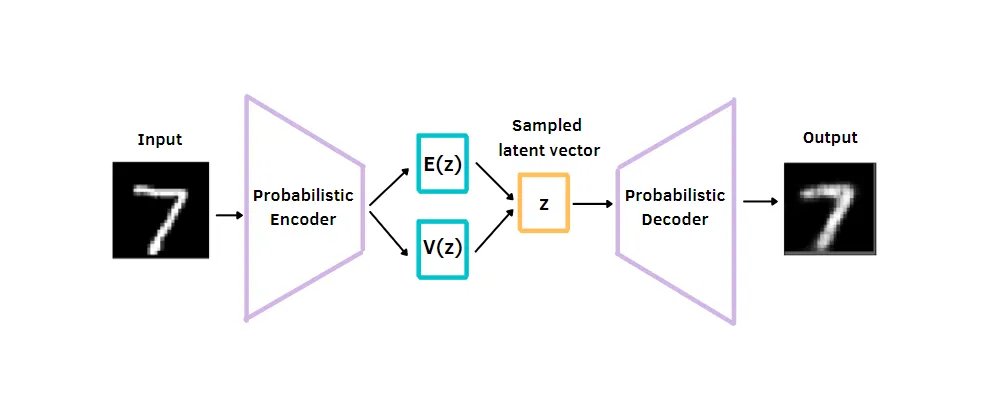
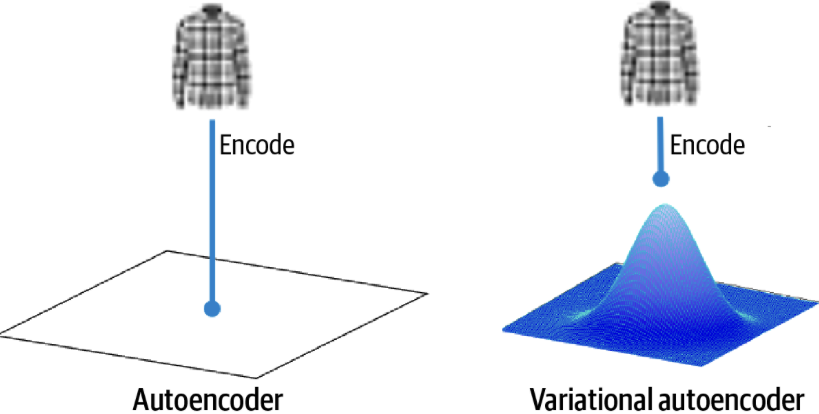
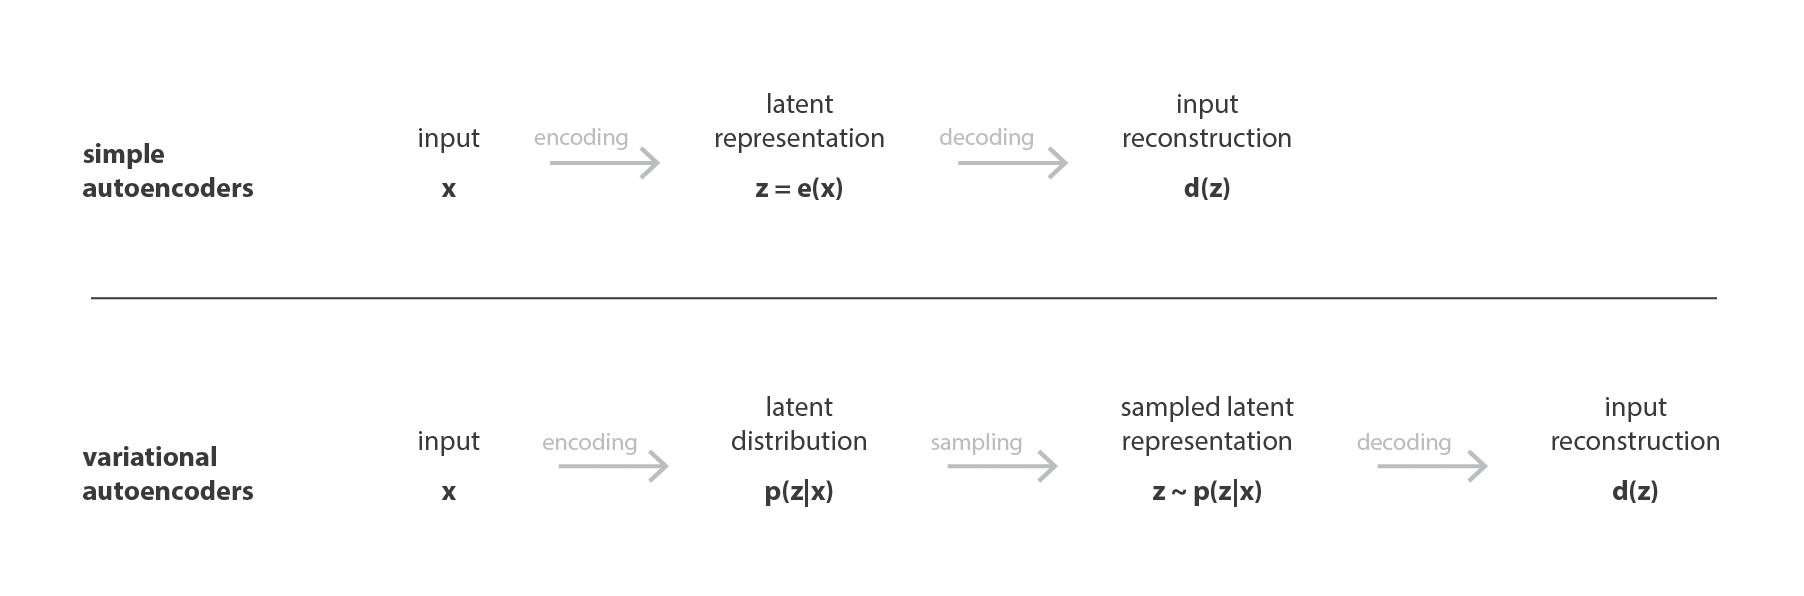

# **1. Loss of VAE : ELBO**

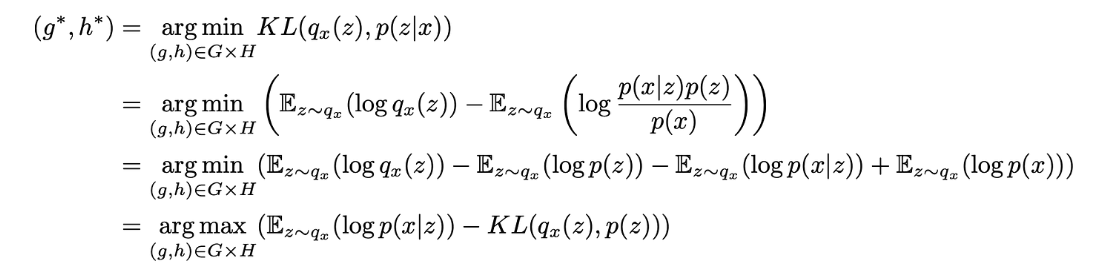

## **or we can minimize the negative of -**

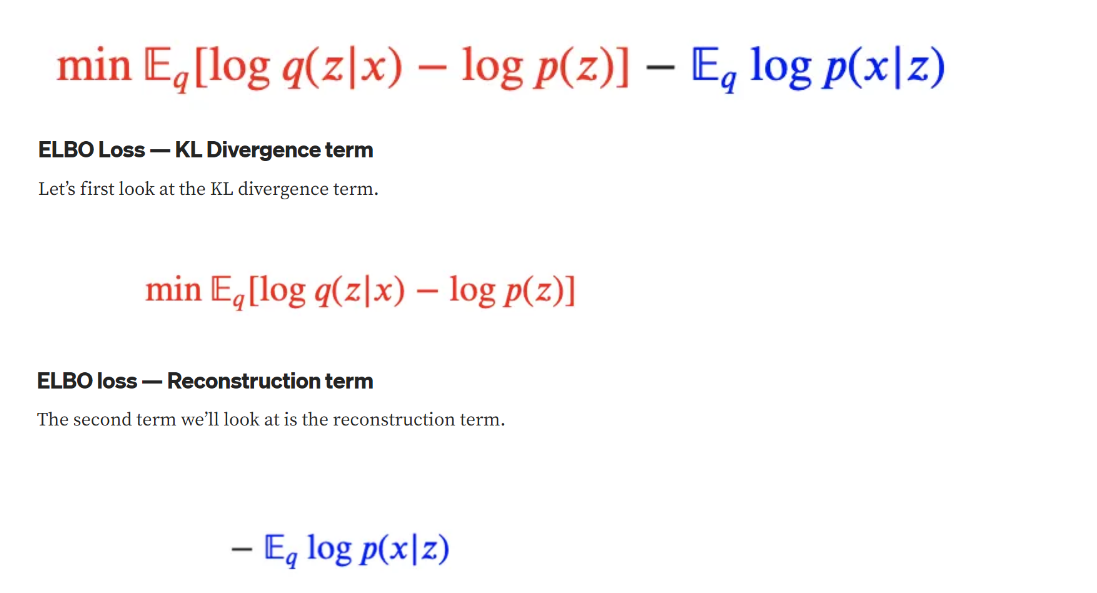


# **2. Loss of VAE :**
## **if reconstruction Loss is MSE and p, q are Normal distributions, the Loss :**

# $$ -0.5 \sum{1 + \log{(\sigma)} - \mu^2 - e^{\log{(\sigma)}}} + Recons Loss(MSE) $$


# **Will implement for both the Loss**


# **[Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)**

In [1]:
!pip install --quiet lightning-bolts
!pip install --quiet pytorch-lightning

In [16]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from pl_bolts.models.autoencoders.components import (resnet18_decoder,resnet18_encoder)
import warnings
warnings.filterwarnings("ignore")

In [7]:
class VAEELBO(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
    def forward(self,x):
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)
        
        return mu,std,x_hat,z
        

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def loss_function(self,mu,std,x,x_hat,z):
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        # kld loss
        kl = self.kl_divergence(z, mu, std)
        # toatal loss
        elbo = (kl - recon_loss)
        
        return {'elbo': elbo.mean(),
                'kl': kl.mean(),
                'recon_loss': recon_loss.mean()}
                

    def training_step(self, batch, batch_idx):
        x, _ = batch
        mu,std,x_hat,z = self.forward(x)
        total_loss = self.loss_function(mu,std,x,x_hat,z)
        return total_loss['elbo']
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        mu,std,x_hat,z = self.forward(x)
        total_loss = self.loss_function(mu,std,x,x_hat,z)
        self.log('val_loss', total_loss['elbo'], on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


In [8]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule(batch_size=512)

In [9]:
pl.seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    dirpath = '/kaggle/working/checkpoints',
    filename = 'BestVAE_ELBO',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

vaeelbo = VAEELBO()


trainer = pl.Trainer(accelerator='gpu',
                     devices=-1,
                     max_epochs=100,
                     check_val_every_n_epoch=5,
                     callbacks=[checkpoint_callback])

In [10]:
trainer.fit(model=vaeelbo, datamodule=datamodule)

Files already downloaded and verified
Files already downloaded and verified


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
cppath = '/kaggle/working/checkpoints/BestVAE_ELBO.ckpt'
checkpoint = torch.load(cppath)
vaeelbo.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [17]:
def generate_images():

    figure(figsize=(8, 3), dpi=300)

    # Z COMES FROM NORMAL(0, 1)
    num_preds = 16
    rand_v = torch.rand(num_preds, vaeelbo.hparams.latent_dim)
    p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v))
    z = p.rsample()
    
    vaeelbo.eval()

    # SAMPLE IMAGES
    with torch.no_grad():
        pred = vaeelbo.decoder(z.to(vaeelbo.device)).cpu()

    # UNDO DATA NORMALIZATION
    # normalize = cifar10_normalization()
    # mean, std = np.array(normalize.mean), np.array(normalize.std)
    img = make_grid(pred).permute(1, 2, 0).numpy() # * std + mean

    # PLOT IMAGES
    plt.imshow(img)
    plt.axis('off')
    plt.show()

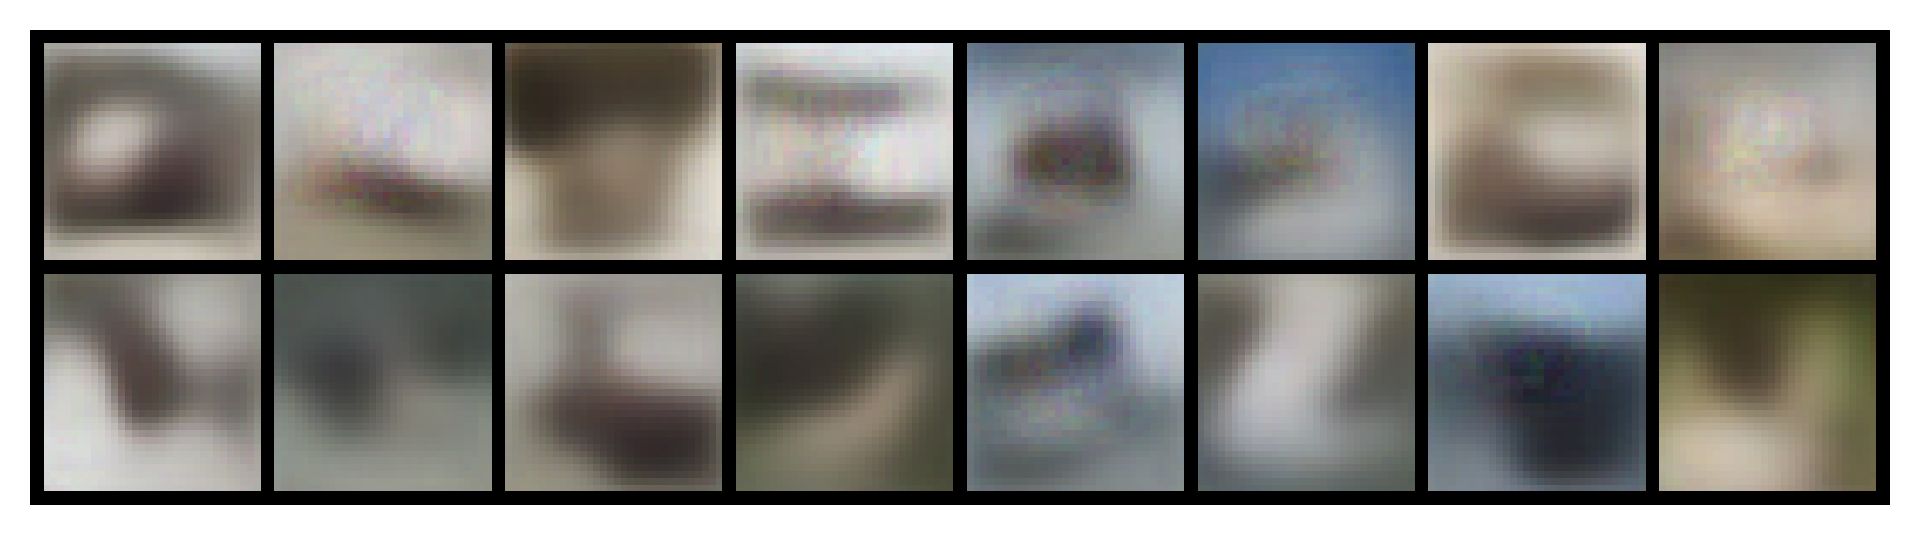

In [18]:
generate_images()

# **2. Loss of VAE :**
## **if reconstruction Loss is MSE and p, q are Normal distributions, the Loss :**

# $$ -0.5 \sum{1 + \log{(\sigma)} - \mu^2 - e^{\log{(\sigma)}}} + Recons Loss(MSE) $$


In [19]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))


    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        
        x_encoded = self.encoder(x)
        mu, logvar = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def loss_function(self, recons ,input, mu, log_var):

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}



    def training_step(self, batch, batch_idx):
        x, _ = batch

        x_hat, mean, logvar = self.forward(x)

        total_loss = self.loss_function(x_hat,x,mean,logvar)

        return total_loss['loss']

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mean, logvar = self.forward(x)
        total_loss = self.loss_function(x_hat,x,mean,logvar)
        self.log('val_loss', total_loss['loss'], on_step=True, on_epoch=True, prog_bar=True)


    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-4)


In [22]:

vae = VAE()


trainer = pl.Trainer(accelerator='gpu',
                     devices=-1,
                     max_epochs=100,
                     check_val_every_n_epoch=5,
                     callbacks=[checkpoint_callback])

In [ ]:
trainer.fit(model=vae, datamodule=datamodule)

In [ ]:
def generate_images():

    figure(figsize=(8, 3), dpi=300)

    # Z COMES FROM NORMAL(0, 1)
    num_preds = 16
    rand_v = torch.rand(num_preds, vae.hparams.latent_dim)
    p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v))
    z = p.rsample()
    
    vae.eval()

    # SAMPLE IMAGES
    with torch.no_grad():
        pred = vae.decoder(z.to(vae.device)).cpu()

    # UNDO DATA NORMALIZATION
    # normalize = cifar10_normalization()
    # mean, std = np.array(normalize.mean), np.array(normalize.std)
    img = make_grid(pred).permute(1, 2, 0).numpy() # * std + mean

    # PLOT IMAGES
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
generate_images()